In [1]:
import sys
sys.path.append('./py/')

In [2]:
import ee
import wxee
import geopandas as gpd
import xarray as xr
import semantique as sq
import json
import time
from config import *
from dynamic_product import Product
from shapely.geometry import shape
from semantique.dimensions import TIME, SPACE, X, Y
import rasterio

In [3]:
credentials = ee.ServiceAccountCredentials(service_account, ee_key)
ee.Initialize(
    credentials,
    # project  ##Specify the project
    opt_url='https://earthengine-highvolume.googleapis.com'
)

In [4]:
product = Product(ROI, layout_path)
bound = product.bound()

In [5]:
image_collected, total_image_collected, iso_dates = product.select_product()

Updated layout saved to D:\OneDrive - Universität Salzburg\EO_Analytics\DynamicWorldDataCube\layout.json.


In [6]:
geometry = shape(json.loads(bound.toGeoJSONString()))
space = sq.SpatialExtent(gpd.GeoDataFrame([{'geometry': geometry}]))
space

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.010980523970677, 47.82432619322555),
      (13.010980523970677, 47.789046341180615),
      (13.072778619673802, 47.789046341180615),
      (13.072778619673802, 47.82432619322555),
      (13.010980523970677, 47.82432619322555)),)},
   'bbox': (13.010980523970677,
    47.789046341180615,
    13.072778619673802,
    47.82432619322555)}],
 'bbox': (13.010980523970677,
  47.789046341180615,
  13.072778619673802,
  47.82432619322555),
 'crs': 'EPSG:4326'}

In [7]:
time = sq.TemporalExtent(*[iso_dates[0], iso_dates[-1]])
time

{'type': 'Interval',
 'start': '2022-01-13T10:17:34',
 'end': '2022-03-01T10:07:38',
 'tz': 'UTC'}

In [8]:
spatial_resolution=[-8.983152841195214829e-05, 8.97e-05]
extent = sq.processor.utils.parse_extent(space, time,  spatial_resolution, crs=4326)

In [9]:
# ds = xr.open_dataset(image_collected, engine='ee',crs='EPSG:4326', geometry=bound, scale=8.983152841195214829e-05)
# ds

In [10]:
ds = image_collected.wx.to_xarray(crs='EPSG:4326', scale=10, region=bound)
ds

Requesting data:   0%|          | 0/20 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (time: 20, x: 689, y: 393)
Coordinates:
  * time                (time) datetime64[ns] 2022-01-13T10:17:34 ... 2022-03...
  * x                   (x) float64 13.01 13.01 13.01 ... 13.07 13.07 13.07
  * y                   (y) float64 47.82 47.82 47.82 ... 47.79 47.79 47.79
    spatial_ref         int32 0
Data variables:
    water               (time, y, x) float64 0.03913 0.03906 0.04098 ... nan nan
    trees               (time, y, x) float64 0.08181 0.08891 0.09509 ... nan nan
    grass               (time, y, x) float64 0.02404 0.02756 0.03012 ... nan nan
    flooded_vegetation  (time, y, x) float64 0.0235 0.02511 0.02654 ... nan nan
    crops               (time, y, x) float64 0.02314 0.02428 0.02365 ... nan nan
    shrub_and_scrub     (time, y, x) float64 0.03307 0.03305 0.03406 ... nan nan
    built               (time, y, x) float64 0.7228 0.706 0.6874 ... nan nan nan
    bare                (time, y, x) float64 0.02569 0.02663 0.02934 ... nan nan
    snow_and_ice        (time, y, x) float64 0.02683 0.02942 0.03278 ... nan nan
    label               (time, y, x) float32 6.0 6.0 6.0 6.0 ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [11]:
import copy

def lookup(layout, *reference):
    obj = layout
    for key in reference:
        try:
            obj = obj[key]
        except KeyError:
            raise KeyError(f"The EO data cube does not contain layer '{reference}'")
    return obj
    
def _parse_layout(obj):
    # Function to recursively parse and metadata objects to make them autocomplete friendly
    def _parse(current_obj, ref_path):
        if "type" in current_obj and "values" in current_obj:
            current_obj["reference"] = copy.deepcopy(ref_path)
            if isinstance(current_obj["values"], list):
                current_obj["labels"] = {
                    item["label"]: item["id"] for item in current_obj["values"]
                }
                current_obj["descriptions"] = {
                    item["description"]: item["id"]
                    for item in current_obj["values"]
                }
            return

        # If not a "layer", traverse deeper into the object.
        for key, value in current_obj.items():
            if isinstance(value, dict):
                new_ref_path = ref_path + [key]
                _parse(value, new_ref_path)

    # Start parsing from the root object.
    for key, value in obj.items():
        if isinstance(value, dict):
            _parse(value, [key])
    return obj


In [12]:
with open(layout_path, 'r') as file:
    json_data = json.load(file)
    
layout = _parse_layout(json_data)
metadata = lookup(layout, "appearance", "colortype")

obj = json.load(open('./layout.json'))
value_labels = {}
for x in obj['appearance']['colortype']['values']:
    try:
        label = x["label"]
    except KeyError:
        label = None
    value_labels[x["id"]] = label
value_labels

{0: 'water',
 1: 'trees',
 2: 'grass',
 3: 'flooded_vegetation',
 4: 'crops',
 5: 'shrub_and_scrub',
 6: 'built',
 7: 'bare',
 8: 'snow_and_ice',
 9: 'label'}

In [22]:
data = ds['label']

keep_coords = ["time", data.rio.x_dim, data.rio.y_dim]

drop_coords=[x for x in list (data.coords) if x not in keep_coords]
data = data.drop_vars(drop_coords)

data = data.sq.write_tz("UTC")
data = data.sq.tz_convert(extent.sq.tz)
data = data.sq.write_spatial_resolution(extent.sq.spatial_resolution)
data = data.sq.rename_dims({data.rio.y_dim: Y, data.rio.x_dim: X})
data = data.sq.write_spatial_resolution(extent.sq.spatial_resolution)

data.coords["spatial_feats"] = ([Y, X], extent["spatial_feats"].data)

data.sq.value_type= 'ordinal'

data.sq.value_labels = value_labels
data[TIME].sq.value_type = "datetime"
data['x'].sq.value_type = "continuous"
data['y'].sq.value_type = "continuous"

data = data.where(data != data.rio.nodata)
data = data.where(data["spatial_feats"].notnull())
data = data.sq.trim()
data = data.astype("float")

In [23]:
data

<xarray.DataArray 'label' (time: 4, y: 393, x: 689)>
array([[[6., 6., 6., ..., 8., 8., 8.],
        [6., 6., 6., ..., 8., 8., 8.],
        [6., 6., 6., ..., 8., 8., 6.],
        ...,
        [4., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 6.],
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 6.],
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.]]])
Coordinates:
  * x              (x) float64 13.01 13.01 13.01 13.01 ... 13.07 13.07 13.07
  * y              (y) float64 47.82 47.82 47.82 47.82 ... 47.79 47.79 47.79
    temporal_ref   int32 0
  * time           (time) datetime64[ns] 2022-01-13T10:17:34 ... 2022-02-12T1...
    spatial_feats  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0
    value_type:              ordinal
    value_labels:            {0: 'water', 1: 'trees', 2: 'grass', 3: 'flooded...

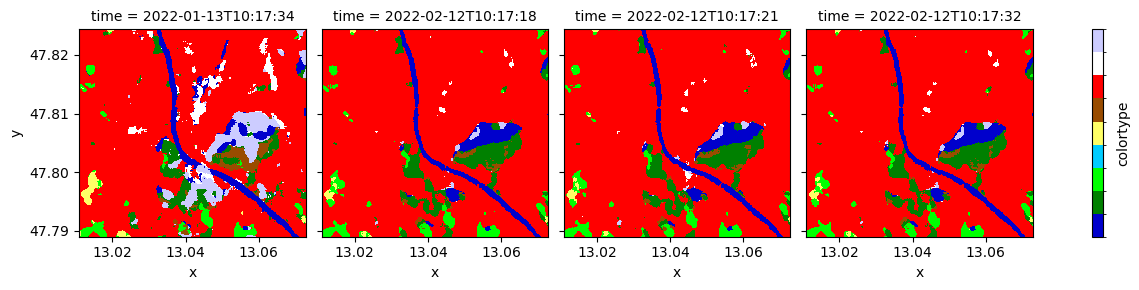

In [24]:
import numpy as np

colors = {
    "water": [0, 0, 204],
    "trees": [0, 128, 0],
    "grass": [0, 255, 0],
    "flooded_vegetation": [0, 204, 255],
    "crops": [255, 255, 102],
    "shrub_and_scrub": [153, 76, 0],
    "built": [255, 0, 0],
    "bare": [255, 255, 255],
    "snow_and_ice": [204, 204, 255],
}

values = list(range(0, 9))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = list([np.array(x)/255 for x in colors.values()])
legend = {"ticks": [], "label": "colortype"}
data.plot(x = "x", y = "y", col = "time", levels = levels, colors = colors, cbar_kwargs = legend);